<div align="right">
  Christopher Lüken-Winkels, Lukas Blecher
</div>
# Exercise 2
## 2 Data Preparation

In [1]:
#import standard libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits
from sklearn import model_selection

In [2]:
digits = load_digits ()
print(digits.keys ()) #Python 3
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [50]:
# filter out all 1's and 7's
# split into train and test data
X_all = data[(target==1)|(target==7)]
y_all = target[(target==1)|(target==7)]
X_train, X_test, y_train , y_test = model_selection.train_test_split(X_all,y_all,test_size = 0.4,random_state = 0)

In [51]:
#verify 3/2 split:
len(X_train)/len(X_test)

1.4896551724137932

### 2.1 Dimension Reduction

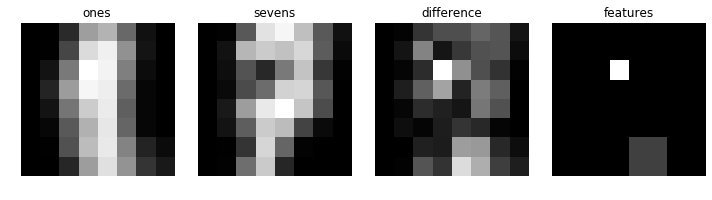

In [5]:
#first look at average of all ones and sevens to identify hot pixels
ones,sevens=images[target==1],images[target==7]
fig = plt.figure(figsize = (10,3))
plt.gray()
plt.subplot('141'); plt.axis('off')
plt.imshow(np.mean(ones,axis=0), interpolation = "nearest")
plt.title('ones')
plt.subplot('142'); plt.axis('off')
plt.imshow(np.mean(sevens,axis=0), interpolation = "nearest")
plt.title('sevens')
plt.subplot('143'); plt.axis('off')
plt.imshow(abs(np.mean(ones,axis=0)-np.mean(sevens,axis=0)), interpolation = "nearest")
plt.title('difference')
plt.subplot('144'); plt.axis('off')
f=np.zeros((8,8))
f[2,3]=1
f[7,4]=f[7,5]=f[6,4]=f[6,5]=.25
plt.imshow(f, interpolation = "nearest")
plt.title('features')
fig.tight_layout(); plt.show()

In the difference plot we can se one very bright pixel in particular. It would be smart to take that pixel value as our first feature. For the second feature we can take an also quite bright pixel region in the lower part of the picture. The average of the four brighter pixel might be a good feature

In [6]:
#reduce dimension function
def reduce_dim(x):
    red=np.zeros((x.shape[0], 2), dtype = np.float64)
    #iterate over the instances
    for i in range(x.shape[0]):
        red[i,0]=x[i,2*8+3]
        red[i,1]=(x[i,7*8+4]+x[i,7*8+5]+x[i,6*8+4]+x[i,6*8+5])/4
    return red

### 2.2 Scatterplot

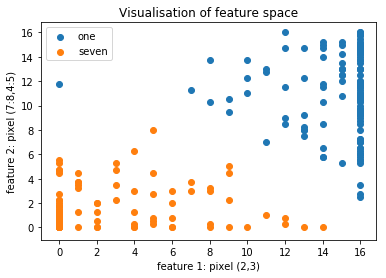

In [150]:
plt.scatter(*reduce_dim(X_train[y_train==1]).T,label='one')
plt.scatter(*reduce_dim(X_train[y_train==7]).T,label='seven')
plt.title('Visualisation of feature space')
plt.xlabel('feature 1: pixel (2,3)')
plt.ylabel('feature 2: pixel (7:8,4:5)')
plt.legend()
plt.show()

## 3 Neares Mean
### 3.1 Implement the nearest mean classifier

In [133]:
def nearest_mean(training_features,training_labels,test_features):
    #list of features:
    features=np.nonzero(np.bincount(training_labels))[0] #is always [1,7] in our example
    #compute per-class centroids
    mu=[]
    #not a bad loop: only 2 iterations. 
    for i in range(len(features)):
        mu.append(np.mean(training_features[training_labels==features[i]],axis=0))
    mu=np.array(mu)
    #now classify the test_features:
    #calculate the distance matrix
    dist=np.sqrt(np.sum(np.square(test_features[:,None]-mu),axis=2))
    #decide which class each element most likley represents
    classes=np.argmin(dist,axis=1)
    #convert from indices of features to the features and return result
    return np.array(list(map(features.__getitem__,classes)))

In [132]:
training_features,test_features=reduce_dim(X_train),reduce_dim(X_test)
guessed_test_labels=nearest_mean(training_features,y_train,test_features)

### 3.2 Visualize the decision regions

In [218]:
#both features are normalized to 16
x,y=np.linspace(-1,17,200),np.linspace(-1,17,200)
X,Y=np.meshgrid(x,y)

In [219]:
#find means:
mu=[np.mean(reduce_dim(X_train[y_train==1]),axis=0),np.mean(reduce_dim(X_train[y_train==7]),axis=0)]

In [220]:
#our classifier is just a nearest neighbor classifier with the only two objects beeing the two means. 
#So our decision region will just be a line through the middle of the two means
def decision_line(x,y,mu): #returns -1 for (x,y) if under and 1 if (x,y) is over the line
    mean=np.mean(mu,axis=0)
    #y=mx+c
    m=-mean[0]/mean[1]
    c=mean[1]-m*mean[0]
    diff=y-(m*x+c)
    return diff/abs(diff)

In [232]:
plt.contourf(X, Y, decision_line(X,Y,mu),1,alpha=.3,cmap=plt.cm.RdBu)
plt.colorbar()
plt.scatter(*reduce_dim(X_train[y_train==1]).T,label='one')
plt.scatter(*reduce_dim(X_train[y_train==7]).T,label='seven')
plt.title('Visualisation of decision regions')
plt.xlabel('feature 1: pixel (2,3)')
plt.ylabel('feature 2:  $\\frac{1}{4} \Sigma$pixel (7:8,4:5)')
plt.plot(*mu[0],'rs',label='mean')
plt.plot(*mu[1],'rs')
#plt.plot(x,decision_line(x,y,mu),color='black')

plt.ylim(-0.5,16.5)
plt.xlim(-0.5,16.5)
plt.legend()
plt.show()

ValueError: 
\frac14 \Sigma
     ^
Expected \frac{num}{den} (at char 5), (line:1, col:6)

<Figure size 432x288 with 2 Axes>

## 4 QDA
### Implement QDA Training